### Importing Necessary Libraries

Starting by importing all the libraries needed for this project. This includes PyTorch for building and training the neural network, `torchvision` for datasets and image transformations, and `matplotlib` and `numpy` for data handling and visualization.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Loading the EMNIST Dataset

Here, I define a simple transformation to prepare the images (converting them to tensors). Then, I load the EMNIST dataset, specifically the 'byclass' split which contains digits and letters. The dataset is downloaded if it's not available locally. Finally, I print the total count of training samples.

In [10]:
transform = transforms.Compose([transforms.ToTensor()])

emnist_data =EMNIST(
    root='./data',
    split='byclass',
    train=True,
    download=True,
    transform = transform
)

print(f"Total samples: {len(emnist_data)}")

Total samples: 697932


### Displaying Sample Images

To get a visual understanding of the data, this function is created to show a few sample images from the dataset. Calling it on the EMNIST data displays some examples.

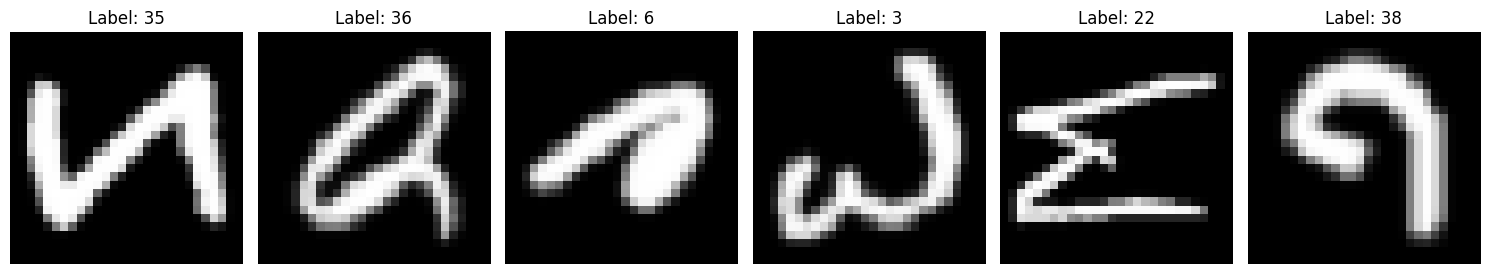

In [11]:
def show_sample_images(dataset, num=6):
  fig, axes = plt.subplots(1, num, figsize=(15,3))
  for i in range(num):
    image, label = dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
  plt.tight_layout()
  plt.show()

show_sample_images(emnist_data)

### Defining the Autoencoder Model

This section defines the structure of the autoencoder model using PyTorch.

*   **Encoder:** Takes an input image, flattens it, and passes it through layers to create a compressed representation.
*   **Decoder:** Takes the compressed representation and uses layers to reconstruct an image of the original size.
*   The `forward` method specifies the data flow from input to output through the encoder and decoder.

In [12]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    # Encoder

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
    )

    # Decoder

    self.decoder = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28))
    )



  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### Setting Up the Data Loader

A `DataLoader` is created for the EMNIST training data. This helps in efficiently processing the data in batches during training. The batch size is set to 128, and the data is shuffled for each training epoch.

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(emnist_data, batch_size=batch_size, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
num_epochs = 5

for epoch in range(num_epochs):
  total_loss = 0
  for images, _ in train_loader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [5/5], Loss: 0.0053


### Visualizing Reconstructed EMNIST Images

After training on EMNIST, this function visualizes how well the autoencoder can reconstruct the original images. It takes a few samples, passes them through the trained model, and displays the original image side-by-side with its reconstruction.

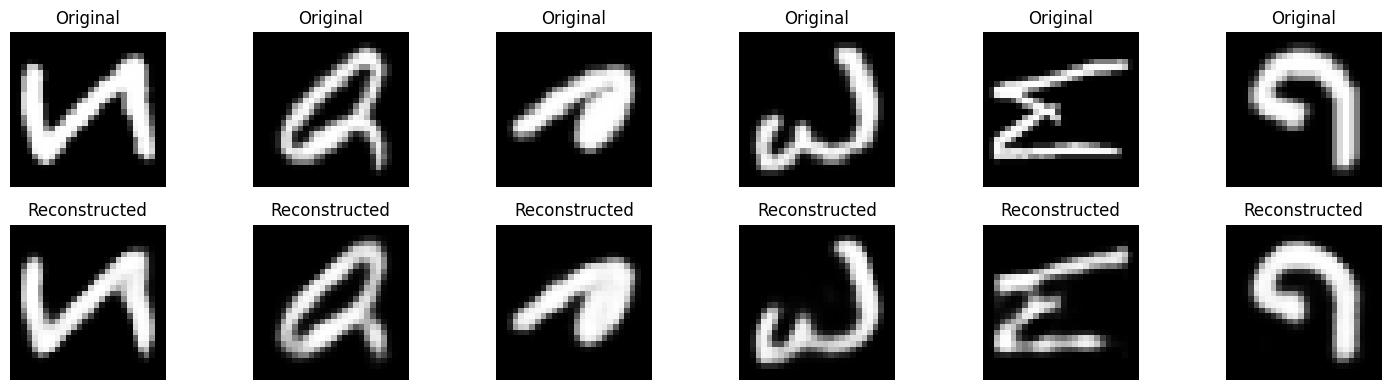

In [8]:
def show_reconstructed(model, dataset, num=6):
  model.eval()
  images, _ = zip(*[dataset[i] for i in range(num)])
  images = torch.stack(images).to(device)
  with torch.no_grad():
    outputs = model(images)

  fig, axs = plt.subplots(2, num, figsize=(15,4))
  for i in range(num):
    axs[0][i].imshow(images[i].cpu().squeeze(),cmap='gray')
    axs[0][i].set_title("Original")
    axs[0][i].axis('off')

    axs[1][i].imshow(outputs[i].cpu().squeeze(),cmap='gray')
    axs[1][i].set_title("Reconstructed")
    axs[1][i].axis('off')

  plt.tight_layout()
  plt.show()

show_reconstructed(model, emnist_data)


In [17]:
from google.colab import drive, files
uploaded = files.upload()

Saving WhatsApp Image 2025-06-21 at 00.26.00_84d886d6.jpg to WhatsApp Image 2025-06-21 at 00.26.00_84d886d6.jpg


In [19]:
import cv2
import numpy as np
import os
from PIL import Image

In [20]:
img = cv2.imread('/content/data.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.bitwise_not(img)

### Extracting Individual Characters

This part focuses on isolating each character from the custom image. It involves applying thresholding to create a binary image, finding contours (outlines), sorting them, and then cropping and resizing each character to 28x28 pixels. The extracted characters are also saved as individual files.

In [22]:
_, thresh = cv2.threshold(img, 100, 255,cv2.THRESH_BINARY)
contours,_ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

char_images = []
for i, cnt in enumerate(contours):
  x, y, w, h = cv2.boundingRect(cnt)
  char = img[y:y+h, x:x+w]
  char = cv2.resize(char, (28, 28))
  char_images.append(char)


for i, char in enumerate(char_images):
  cv2.imwrite(f"char_{i}.png",char)

print(f"Extracted {len(char_images)} charaters")

Extracted 982 charaters


### Creating a Custom Dataset

A custom PyTorch `Dataset` class is defined to handle the extracted character images. It converts the images to tensors, adds a channel dimension, and normalizes the pixel values, making them ready for use with PyTorch's DataLoader.

In [23]:
from torch.utils.data import Dataset

class CustomHandwritingDataset(Dataset):
  def __init__(self,char_images):
    self.images = [torch.tensor(img, dtype=torch.float32).unsqueeze(0)/255. for img in char_images]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index], 0

### Fine-tuning on Custom Handwriting Data

This section prepares the custom data for training and then fine-tunes the autoencoder on the extracted characters. A DataLoader is created for the custom dataset. **Note:** The line `model = Autoencoder().to(device)` re-initializes a new model. To continue training from the EMNIST pre-training, this line should be removed. A training loop then runs for 100 epochs to adapt the model to the specific handwriting style. The loss is printed periodically during this process.

In [24]:
custom_dataset = CustomHandwritingDataset(char_images)
custom_loader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

model = Autoencoder().to(device)

for epoch in range(100):
  for images, _ in custom_loader:
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 10 ==0:
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")




Epoch 0, Loss: 0.0107
Epoch 10, Loss: 0.0141
Epoch 20, Loss: 0.0106
Epoch 30, Loss: 0.0105
Epoch 40, Loss: 0.0109
Epoch 50, Loss: 0.0109
Epoch 60, Loss: 0.0112
Epoch 70, Loss: 0.0110
Epoch 80, Loss: 0.0125
Epoch 90, Loss: 0.0154


### Visualizing Reconstructed Custom Images

Finally, this cell visualizes the reconstruction results using the fine-tuned autoencoder on the custom dataset. It displays the original extracted characters alongside their reconstructed versions, showing the model's performance on your handwriting.

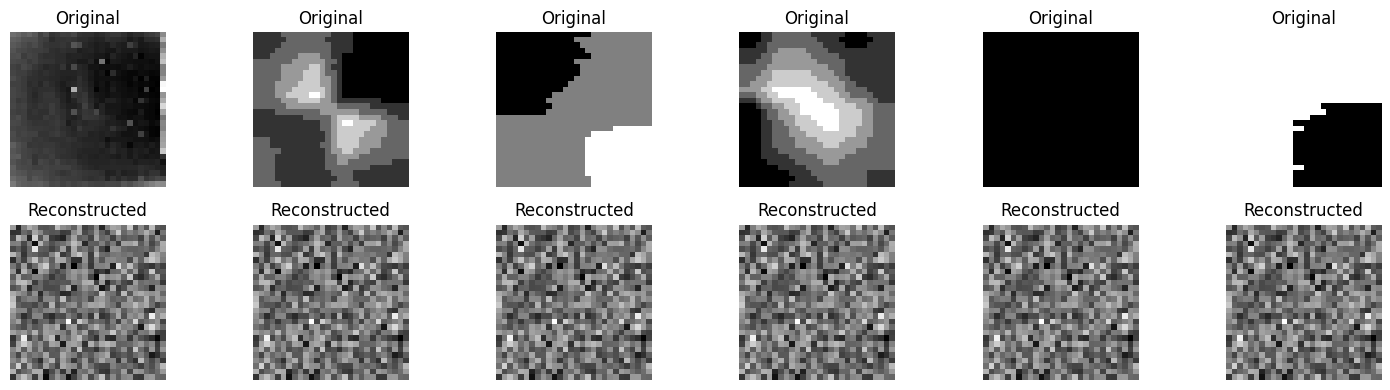

In [25]:
show_reconstructed(model, custom_dataset)